In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,5

Populating the interactive namespace from numpy and matplotlib


Based on the characterization of the Axon-Hillock design performed in AHOsc_Char.ipynb, we have one good solution for large currents and two possible solutions for small currents.  This notebook will be used to help us debug and optimize these circuits until we have a promising final solution.  Hopefully, once we've optimized these circuits, we will be able to use them for the current proposed ADC (an Analog to Time to Digital Converter, ATDC).

The other more pressing reason for forking this notebook from the previous notebook was to clean up the code and shorten the notebook length.

In [2]:
import os
import sys
from scipy.optimize import leastsq
from pylab import *
import csv
import mpld3
from IPython.display import Image

# Global Functions and Variables

In [3]:
sampleTime = 20e-6

folderPath="/home/noza/work/Braindrop/CDB/BDTests/AHOsc_test/Measurements/"

# This readFile to takes the average value of every other column
def readFile(filePath):
    data = genfromtxt(filePath, dtype=float, delimiter=",", skip_header=1)
    sampleFreqs = data[:,1::2]
    return nanmean(sampleFreqs, axis=0)

# This file will read the params csv file (saved by the Parametric Analysis tool)
# (In the future make this more generic, with input array set in order of CSV file rows)
def readParams(paramFile):
    for i, row in enumerate(csv.reader(paramFile)):
        if i == 0:
            temps = [int(i) for i in array(row[1:])]
            print "Temps: ", temps
        elif i==1:
            Iins = array(double(row[1:]))
            print "Iins: ", Iins
        else:
            print "Too many rows"
    return temps, Iins

# Generic plotting tool that takes a temperature value to also print in the label
def plotGen(Xs, Ys, temp, pltRange, plotType='.-', 
            plotLog=False, ttl='Default Title', xlbl='xLabel', ylbl='yLabel', color=(1,0,0,1)):
    rangeX, rangeY = pltRange[0], pltRange[1]    
    lenYs = len(Ys)
    if plotLog:
        loglog(Xs[:lenYs],Ys, plotType, label=str(temp)+"C", color=color)
    else:
        plot(Xs[:lenYs],Ys, plotType, label=str(temp)+"C", color=color)
    xlabel(xlbl)
    ylabel(ylbl)
    title(ttl)
    xlim(rangeX)
    ylim(rangeY)

In [4]:
# These functions define the equation used to fit the data points.
def linfit(xdata, params):
    m, b, I0 = params
    return m/(xdata-I0) + b

def linfitErr(params, xdata, ydata):
    m, b, I0 = params
    return ydata - (m/(xdata-I0) + b)

In [5]:
# Getter functions to convert a string to a value for handling units
def getTScaleVal(TScaleFactor):
    if TScaleFactor in ['n', 'ns']:
        TScale = 1e-9
        TLbl = '$T(ns)$'
    elif TScaleFactor in ['u', 'us']:
        TScale = 1e-6
        TLbl = '$T(\mu s)$'
    elif TScaleFactor in ['m', 'ms']:
        TScale = 1e-3
        TLbl = '$T(ms)$'
    elif TScaleFactor <= 1:
        TScale = 1
        TLbl = '$T(s)$'
    return TScale, TLbl

def getIScaleVal(IScaleFactor):
    if IScaleFactor in ['f', 'fa', 'fA']:
        IScale = 1e-15
        ILbl = '$\\frac{1}{I_{in}} (\\frac{1}{fA})$'
    elif IScaleFactor in ['p', 'pa', 'pA']:
        IScale = 1e-12
        ILbl = '$\\frac{1}{I_{in}} (\\frac{1}{pA})$'
    elif IScaleFactor in ['n', 'na', 'nA']:
        IScale = 1e-9
        ILbl = '$\\frac{1}{I_{in}} (\\frac{1}{nA})$'
    return IScale, ILbl

In [6]:
# Plot T (period) vs 1/Iin (inverse input current)   
def plotLinearityT(curinvIins, curAH_Ts, curTemp, x_th, Ts_th, xMax, yMax, dxMax, dyMin, dyMax,
                   xLbl='$\\frac{1}{I_{in}} (\\frac{1}{nA})$',yLbl='$T(\mu s)$',):
    # Determine Color Value
    curTempScale = float(curTemp)/50
    col = (curTempScale,0,1-curTempScale,1)
    
    subplot(1,2,1)
    # Plot on a linear scale
    plotGen(curinvIins, curAH_Ts, curTemp, [[0,xMax], [0,yMax]],
            plotType = '.',
            ttl='Ring Oscillator Period',
            xlbl=xLbl,
            ylbl=yLbl,
            color=col)
    
    # Plot the linear fit
    plot(1./x_th, Ts_th, '-',color=col)
    
    subplot(1,2,2)
    # Plot the derivative
    derivTs = diff(curAH_Ts)/diff(curinvIins)
    #plotGen(curinvIins[1:], derivTs, curTemp, [[0,max(curinvIins[1:])],[min(derivTs),max(derivTs)]],
    plotGen(curinvIins[1:], derivTs, curTemp, [[0,dxMax],[dyMin,dyMax]],
            plotType='-',
            ttl='Derivative of Ring Oscillator Period',
            xlbl=xLbl,
            ylbl='$\\frac{dT}{d\\frac{1}{I_{in}}}$',
            color=col)

# filePath: path to the data file (include the folderPath and fileName)
# Iins: input current in amps
# IScaleFactor: desired input current units
#     (it will apply the appropriate scaling value to Iins (still in Amps))
# TScaleFactor: desired period units
#     (it will apply the appropriate scaling value to time (originally in seconds))
def plotLinearity(filePath, Iins, IScaleFactor='pA', TScaleFactor='ms', Lims=None, dLims=None):
    # Read the input file and extract the frequencies
    AH_Freqs = array(readFile(filePath))
    
    TScale, TLbl = getTScaleVal(TScaleFactor)
    AH_Ts = (1./AH_Freqs)/TScale
    
    IScale, ILbl = getIScaleVal(IScaleFactor)
    scaledIins = Iins/IScale
    invIins = 1./scaledIins
    
    Lims[0] = xLim = max(Lims[0], max(invIins))
    Lims[1] = yLim = max(Lims[1], max(AH_Ts))
    dLims[0] = dxMax = max(dLims[0], max(invIins[1:]))
    dLims[1] = dyMin = min(dLims[1], min(diff(AH_Ts)/diff(invIins)))
    dLims[2] = dyMax = max(dLims[2], max(diff(AH_Ts)/diff(invIins)))

    x_th = linspace(min(scaledIins),max(scaledIins), num=10000)
    sol = leastsq(linfitErr, (1.1, 0.001, 0), (scaledIins, AH_Ts))
    Ts_th = linfit(x_th, sol[0])

    plotLinearityT(invIins, AH_Ts, curTemp, x_th, Ts_th,
                   xLim, yLim, dxMax, dyMin, dyMax, ILbl,TLbl)
    return AH_Ts, sol[0], Lims, dLims

# Plots a series of time points and their y-value at those times
def plotTimeSeries(xVals, yVals, clr=(1,0,0,1), 
                   ttl='', xLbl='', yLbl='',
                   xMin=0, xMax=10, yMin=0, yMax=10):
    if xMin==None:
        xMin = min(xVals)
    if xMax==None:
        xMax = max(xVals)
    if yMin==None:
        yMin = min(yVals)
    if yMax==None:
        yMax = max(yVals)
    plot(xVals,yVals, color=clr)
    xlabel(xLbl)
    ylabel(yLbl)
    title(ttl)
    xlim([xMin,xMax])
    ylim([yMin,yMax])

In [7]:
# Calculate the Relative RMSE of data compared to the fit
def calcRRMSE(Iins, Ts, Params, IScaleFactor):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    scaledIins = Iins/IScale
    thTs = linfit(scaledIins, Params)
    #print (Ts - thTs)
    se = (Ts - thTs)**2
    resSampVar = sum(se)/(len(se)-1)
    #print 'Residual Variance: {}'.format(resSampVar)
    rms = sqrt(mean(thTs**2))
    rrmse = sqrt(resSampVar/rms)
    #print 'Relative RMSE: {:%}'.format(rrmse)
    return rrmse

In [8]:
# This function will print out the percentage of the overall period that is attributed to the inverter delay.
def percPeriodbyDelay(TsAsFuncOfIin, curIins, avgLoopDelay, curTemps):
    print 'Percent of overall period taken by delay from feedback buffer delay'
    print '{:>5s}\t\t'.format("Iins") + "%s"%'\t'.join(curTemps)
    for i, curTs in enumerate(TsAsFuncOfIin):
        #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
        Iins_fA = curIins[i]/10**-15
        percDelay = avgLoopDelay*1e3/curTs
        foo = list()
        for i, curPDelay in enumerate(percDelay):
            #print '\t{:^6.3%}'.format(percDelay[i])
            foo.append('\t{:^6.3%}'.format(percDelay[i]))
        #print foo
        print '{:>5.0f} fA'.format(Iins_fA) + ''.join(foo)

# Calculate the percentage variance that results from the variation in temperature.
# curTemps: When a list of temperatures is passed in, this argument does two things
#    1) It is used as a flag to tell the function to print each periods 
#    deviation from the mean as a signed percentage of the mean.  (It only does this
#    if the number of curTemps is the same as the number of curTs)
#    2) It passes in the array of temperatures to print individual values corresponding
#    temperature 
def percVariancebyTemp(TsAsFuncofIin,curIins,curTemps=None,IScaleFactor='pA'):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    print
    if curTemps:
        print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error(Negative values => Value smaller than mean)")
    else:
        print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
    for i, curTs in enumerate(TsAsFuncOfIin):
        #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
        scIins = curIins[i]/IScale
        re = (max(curTs)-min(curTs))/mean(curTs)  # re = relative error
        print '{:>6.3f} {}\t{:^12.3%}'.format(scIins, IScaleFactor, re)
        
        if curTemps and len(curTemps)==len(curTs):
            for j, curT in enumerate(curTs):
                ire = (curT-mean(curTs))/mean(curTs)   # individual relative error
                print '\t{:>4.1f} C\t{:^12.3%}'.format(curTemps[j], ire)

# Calculate the percentage variance that results from the variation in temperature.
# vals: matrix of dimensions (numIins x numTemps)
# idealVal: the ideal value you want to compare the measurements to
# curIins: array of Iin values (in Amps) of length numIins
# curTemps: array of temperature values (in C) of length numTemps
def percVarReltoIdeal(measVals,idealVal,curIins,curTemps, IScaleFactor):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    print
    for i, curVals in enumerate(measVals):
        print '{:>5s}\t\t{:^2s}\t{:^12s}'.format("Iins", "Temp", "Percent Error")
        for j, curVal in enumerate(curVals[i]):
            scIins = curIins[i]/IScale
            re = (curVal-idealVal)/idealVal
            print '{:>6.3f} {}\t{:^2s}\t{:^12.3%}'.format(scIins, IScaleFactor, curTemps[j], re)
            

# ThinOxide FETs for Large Currents using Source Switches
Below, you will find the final results from AHOsc_Char for the large current sensing AH circuit.  This circuit was made using simple mirrors and ThinFET inverters.  There are three inverters, the first two to create the oscillating waveform and the third to act as the source switches.

These measurements were made without buffers controlling the gates of the current sources.  This sweep also includes sweeping over temperature, so that we can see how this AH circuit will operate, in it's non-ideal, but realistic, configuration.

To get a good idea of how well the fit approximates the data, we also want to calculate the RMSE of the data.  This will give us an idea of what to expect in the actual circuit when it is built.  We can see this in the "Relative RMSE" calculation, calculated using the calcRRMSE function.

The results below also quantify the percentage difference in the period as we sweep over temperatures for the AH circuit analyzed above.

The inverters are sized as shown below: 

    Thin PFET: 90n x 30n
    Thin NFET: 80n x 30n
   
Our circuit's requirements for large input currents (10pA to 10nA) is to be able to have a maximum period length of $20\mu s$ for the smallest input current and a <1% error in period measurements over $50^{\circ}C$.

Temps:  [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
Iins:  [  1.00000000e-11   2.15443469e-11   4.64158883e-11   1.00000000e-10
   2.15443469e-10   4.64158883e-10   1.00000000e-09   2.15443469e-09
   4.64158883e-09   1.00000000e-08]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp0C.csv
Temp:  0	Relative RMSE: 0.393283%	Params: [  4.61411108e-01   2.27275800e-02  -2.17002737e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp5C.csv
Temp:  5	Relative RMSE: 0.391934%	Params: [  4.62080355e-01   2.24899703e-02  -2.19749705e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp10C.csv
Temp: 10	Relative RMSE: 0.391342%	Params: [  4.62739016e-01   2.22970201e-02  -2.22033688e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp15C.csv
Temp: 15	Relative RMSE: 0.390903%	Params: [  4.63386917e-01   2.21253037e-02  -2.24812420e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp20C.csv
Temp: 20	Relative RMSE: 0.388236%	Params: [  4.64042210e-01   2.19091406e-02  -2.28111216e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_T

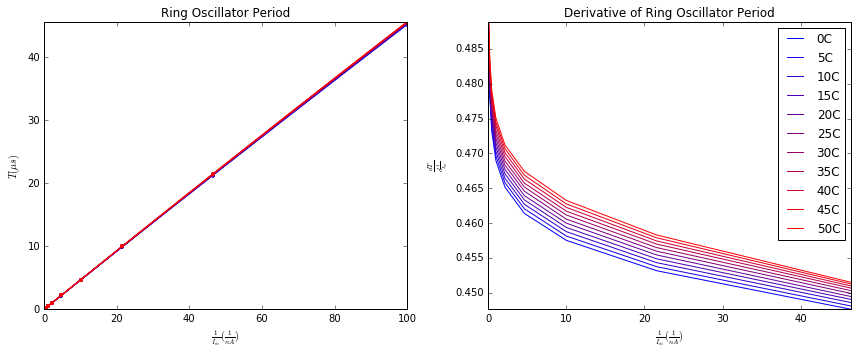

In [19]:
Temps, Iins = readParams(open(folderPath+"SweptParams.csv"))
allTs = []
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in Temps:
    fileName = "AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, Iins, 
                                        IScaleFactor='nA', TScaleFactor='us',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    print 'Temp: {:>2}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(Iins, curTs,
                                                                       curFitParams, IScaleFactor='nA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, Iins, IScaleFactor='nA')
#percVariancebyTemp(TsAsFuncOfIin, Iins, Temps, IScaleFactor='nA')
#mpld3.display()    # Display the plots in interactive mode

# ThickOxide Inverter for Slow Input Currents
For smaller currents, we found in AHOsc_Char that we can change the inverters, in the feedback chain of inverters, to ThickFET transistors.  The reason we think we can get away with using ThickFETs for smaller currents is because the inverter's gain will still be much faster than the capacitor's charging speed, and as such the non-linearity introduced by the ThickFET will be a much smaller proportion of the switching time of the oscillator.  The sweep will range from 10fA to 10pA (to cover the remaining 2 orders of magnitude).

In this section we compare two biasing circuits (to set the "current source" values).  We are going to investigate Kwabena's Mirror (previously known as the Vcap-based biasing) compared to Ben's Mirror.  We want to analyze these mirrors in more detail to find out which one behaves more ideally over temperature for our input currents.  If we are able to do this, then we will have a better understanding of where our problems are coming from and will therefore be able to make a more informed decision regarding which architecture to use (assuming we can optimize the speeds further).

_Note: To speed up simulation time, I am going to continue to do abridged sweeps of temperatures and $I_{in}$.  Temperature will be swept from $0^{\circ}C-50^{\circ}C$ in 3 equal steps, and input current will have 5 logarithmic steps from 100fA to 10pA._

Our circuit's requirements for small input currents (100fA to 10pA) is to be able to have a maximum period length of 1ms for the smallest input current and a <1% error in period measurements over $50^{\circ}C$.

## Bias Circuit Analysis
In our bias circuits, we essentially have two problems to solve/balance in order to ensure that input current is accurately mirrored to set the two current sources (the charging and discharging currents).  The first problem is that we want to ensure that we don't run out of headroom while setting any of the current values.  The second problem is to ensure that none of the transistors unintentionally pinch the current in the circuit.  This second problem could arise from having the $V_{ds}$ value of a transistor become too small.  We want to do all of this while keeping our current consumption to a minimum, keeping temperature variance in check and making the circuit fast enough.

### Kwabena's Mirror ($V_{cap}$-based biasing)
In this circuit, we use the $V_{cap}$ signal to control a common gate amplifier.  This allows the mirror's $V_{ds}$ to be set to a much closer value (similar to a complex mirror).

To simplify the thinking, as a baseline for this bias, I have all of the transistors set as 1W and 1L, except P11 and N20, as shown in the schematic below.

We make the bias transistors N20 and P11 longer, thereby making it so that the current source pulling $I_b$ doesn't require as much current.  This will help with the power consumption of the circuit.  This was shown to work well in the previous notebook, as shown in the test results copied from that section.  As such, we will use this as the baseline for this section.

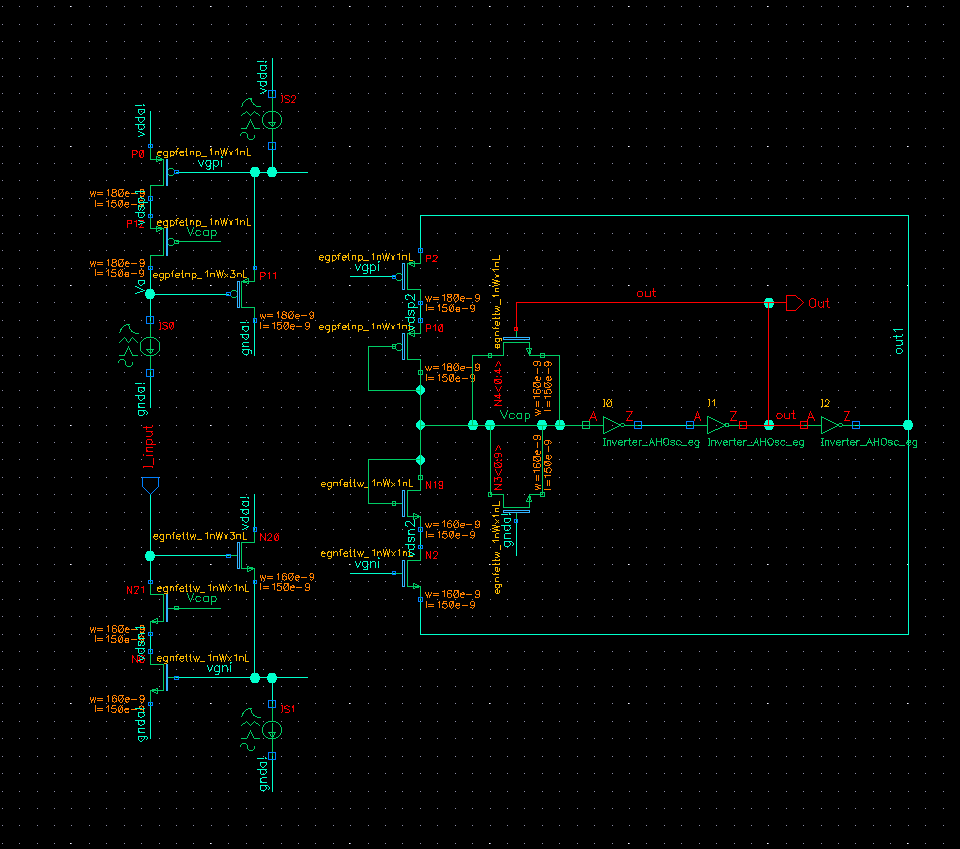

In [33]:
Image(folderPath + "SchematicImages/AHConfig_VcapBasedCS_LongerFdbkTxr_NoBuf_C1_10x_C2_5x.png", width=800)

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-13   3.16227766e-13   1.00000000e-12   3.16227766e-12
   1.00000000e-11]
AH_VcapBasedCS_LongFdbkTxrs/AH_Inv_FreqMeas_Temp0C_NoBuf_Ib500p_C1_10x_C2_5x.csv
Temp: 0	Relative RMSE: 0.017124%	Params: [  1.05027435e+00   1.46251178e-03  -1.13565112e-04]
AH_VcapBasedCS_LongFdbkTxrs/AH_Inv_FreqMeas_Temp25C_NoBuf_Ib500p_C1_10x_C2_5x.csv
Temp: 25	Relative RMSE: 0.012516%	Params: [  1.04987150e+00   1.03024389e-03  -1.61982796e-04]
AH_VcapBasedCS_LongFdbkTxrs/AH_Inv_FreqMeas_Temp50C_NoBuf_Ib500p_C1_10x_C2_5x.csv
Temp: 50	Relative RMSE: 0.011778%	Params: [  1.05011206e+00   7.61542628e-04  -8.55899064e-04]

 Iins		Percent Error
 0.100 pA	   0.760%   
 0.316 pA	   0.269%   
 1.000 pA	   0.168%   
 3.162 pA	   0.296%   
10.000 pA	   0.479%   


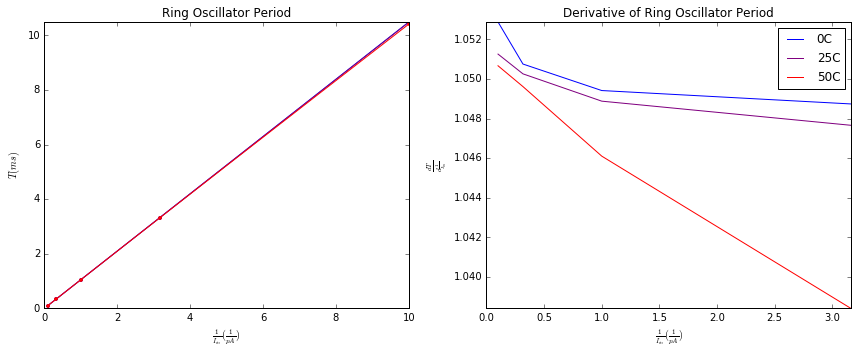

In [9]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_QuickSweep.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_VcapBasedCS_LongFdbkTxrs/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_NoBuf_Ib500p_C1_10x_C2_5x.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

### Ben's Mirror
In this circuit, instead of using a normal complex mirror, we use Ben's modified version, where he adds a bias to tune the $V_{ds}$ values of the mirroring transistors.  This circuit helps buy more headroom because now we can lower the $V_{out}$ (or $V_{cap}$ equivalent) node to 250mV when mirroring current into the PFET portion of the circuit.

In our previous notebook we saw that a buffered version of Ben's mirror works well, but that once we made this unbuffered, the results were terrible.

A schematic of the simplified (everything is 1W, 1L, and min-sized) version of Ben's Mirror is shown below.  We will compare the biasing circuitry of this design to Kwabena's mirror in the next section.

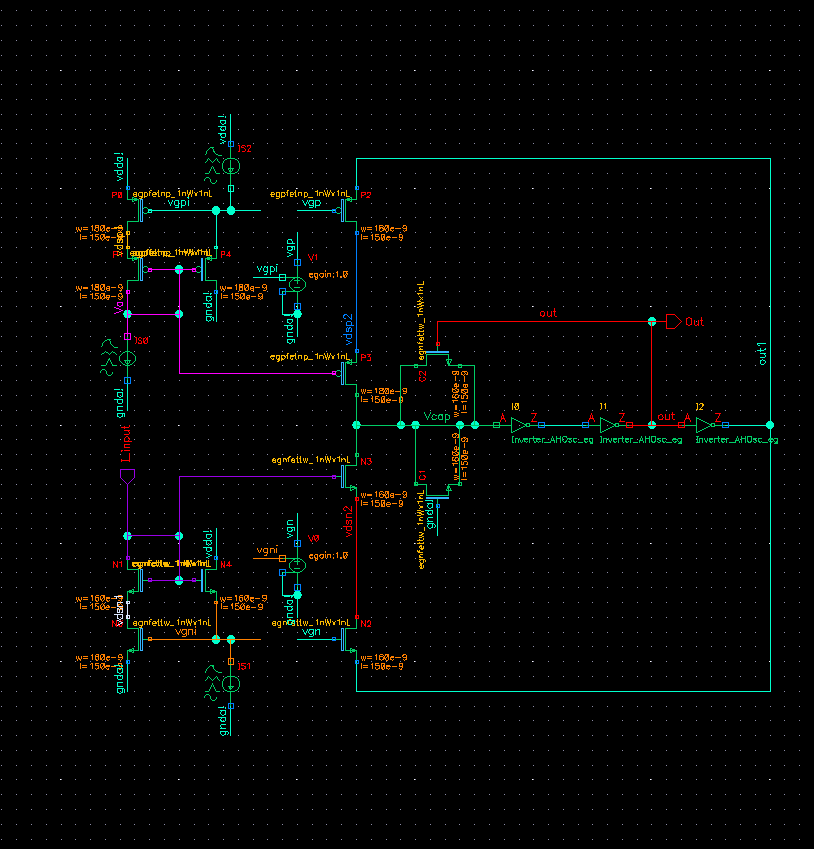

In [34]:
Image(folderPath + "SchematicImages/AHConfig_BensMirror_Simp_C1_1x_C2_1x_Iin1x.png", width=800)

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11   3.16227766e-11
   1.00000000e-10]
AH_Final/AH_FreqMeas_Ben_Temp0C_NoBuf_Ib500f_C1_1x_C2_3x_Iin2x.csv
Temp: 0	Relative RMSE: 2.874947%	Params: [  3.66401276e-01   1.22038906e-01  -3.03501997e-04]
AH_Final/AH_FreqMeas_Ben_Temp25C_NoBuf_Ib500f_C1_1x_C2_3x_Iin2x.csv
Temp: 25	Relative RMSE: 1.713699%	Params: [ 0.35353211  0.08693225  0.00040734]
AH_Final/AH_FreqMeas_Ben_Temp50C_NoBuf_Ib500f_C1_1x_C2_3x_Iin2x.csv
Temp: 50	Relative RMSE: 1.348148%	Params: [ 0.35500359  0.05811927  0.00073958]

 Iins		Percent Error
 0.010 pA	   7.303%   
 0.032 pA	   1.461%   
 0.100 pA	   9.134%   
 0.316 pA	  17.009%   
 1.000 pA	   9.432%   
 3.162 pA	  14.370%   
10.000 pA	  16.189%   
31.623 pA	  18.004%   
100.000 pA	  19.857%   


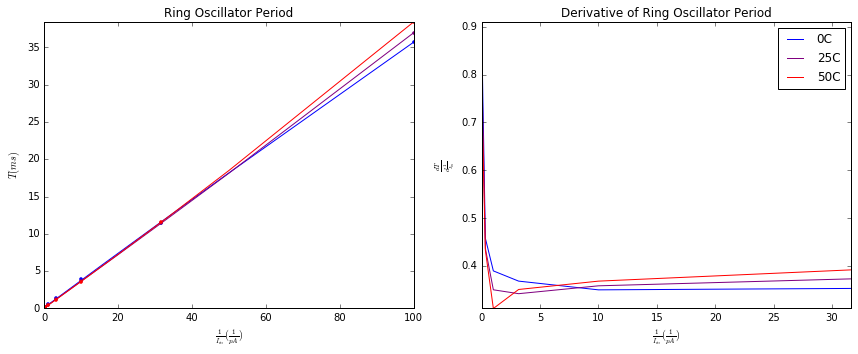

In [29]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto100pA.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_Ben_Temp"+str(curTemp)+"C_NoBuf_Ib500f_C1_1x_C2_3x_Iin2x.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

#### Ben's Mirror with a gate capacitance 20fF

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11   3.16227766e-11
   1.00000000e-10]
AH_Final/AH_FreqMeas_Ben_Temp0C_NoBuf_Ib500f_C1_1x_C2_3x_Iin2x_GateCap20f.csv
Temp: 0	Relative RMSE: 9.729432%	Params: [ 0.38746283 -0.11210741 -0.00047533]
AH_Final/AH_FreqMeas_Ben_Temp25C_NoBuf_Ib500f_C1_1x_C2_3x_Iin2x_GateCap20f.csv
Temp: 25	Relative RMSE: 9.279435%	Params: [ 0.3931758  -0.10913824 -0.00053524]
AH_Final/AH_FreqMeas_Ben_Temp50C_NoBuf_Ib500f_C1_1x_C2_3x_Iin2x_GateCap20f.csv
Temp: 50	Relative RMSE: 7.955207%	Params: [ 0.39099303 -0.09498882 -0.00043405]

 Iins		Percent Error
 0.010 pA	   1.366%   
 0.032 pA	   1.161%   
 0.100 pA	   7.158%   
 0.316 pA	   1.692%   
 1.000 pA	   0.715%   
 3.162 pA	   0.441%   
10.000 pA	   0.452%   
31.623 pA	   2.115%   
100.000 pA	   6.171%   


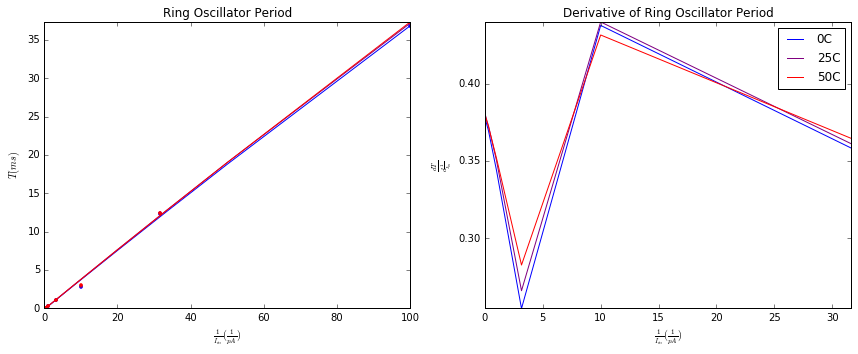

In [30]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto100pA.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_Ben_Temp"+str(curTemp)+"C_NoBuf_Ib500f_C1_1x_C2_3x_Iin2x_GateCap20f.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

## Final Verification of Two Bias system
From our bias current analysis, we found that Kwabena's mirror operates ever so slightly better than Ben's mirror on average.  As a result, the simulations below show some of our final verifications to determine the best KB mirror-based AH design to use in our actual circuit.  Once this is shown below to have sub-1% error, then I will try to remove the dicharging circuitry and substitute it with a really large bias, to make the circuitry behave in an asymmetric manner.  This asymmetry will hopefully buy us the 2x speed up we want without sacrificing any error, and will also ideally help with some of the error introduced at small currents due to gate leakage in the NFETs

### Baseline (10fA to 10pA) C1 1x, C2 1x, Iin 1x, Ib 100p
This should have some minor errors

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_Final/AH_FreqMeas_Temp0C_NoBuf_Ib100p_C1_1x_C2_1x_Iin1x.csv
Temp: 0	Relative RMSE: 0.019196%	Params: [  2.05378149e-01   2.74728120e-03   3.22278287e-06]
AH_Final/AH_FreqMeas_Temp25C_NoBuf_Ib100p_C1_1x_C2_1x_Iin1x.csv
Temp: 25	Relative RMSE: 0.003873%	Params: [  2.06042661e-01   1.58597474e-03  -1.47879925e-04]
AH_Final/AH_FreqMeas_Temp50C_NoBuf_Ib100p_C1_1x_C2_1x_Iin1x.csv
Temp: 50	Relative RMSE: 0.186510%	Params: [ 0.20492417  0.00449004 -0.00116938]

 Iins		Percent Error
 0.010 pA	  11.124%   
 0.032 pA	   3.877%   
 0.100 pA	   0.903%   
 0.316 pA	   0.174%   
 1.000 pA	   0.397%   
 3.162 pA	   1.398%   
10.000 pA	   2.975%   


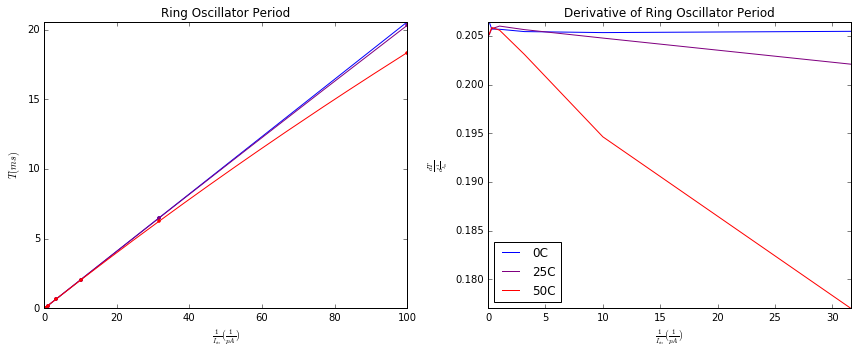

In [24]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]
LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto10pA.csv"))

for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_Temp"+str(curTemp)+"C_NoBuf_Ib100p_C1_1x_C2_1x_Iin1x.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

### Iin range 10fA to 10pA, C1 1x, C2 2x, Iin 1x, Ib 100p
This should behave better, but might still have a problem

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_Final/AH_FreqMeas_Temp0C_NoBuf_Ib100p_C1_1x_C2_2x_Iin1x.csv
Temp: 0	Relative RMSE: 0.026492%	Params: [  4.15459484e-01   2.28774934e-03   4.80685496e-05]
AH_Final/AH_FreqMeas_Temp25C_NoBuf_Ib100p_C1_1x_C2_2x_Iin1x.csv
Temp: 25	Relative RMSE: 0.010492%	Params: [  4.16156312e-01   1.18689945e-03  -7.14809657e-05]
AH_Final/AH_FreqMeas_Temp50C_NoBuf_Ib100p_C1_1x_C2_2x_Iin1x.csv
Temp: 50	Relative RMSE: 0.274725%	Params: [ 0.41263232  0.00836407 -0.00084871]

 Iins		Percent Error
 0.010 pA	   9.176%   
 0.032 pA	   3.487%   
 0.100 pA	   0.946%   
 0.316 pA	   0.199%   
 1.000 pA	   0.169%   
 3.162 pA	   0.482%   
10.000 pA	   1.048%   


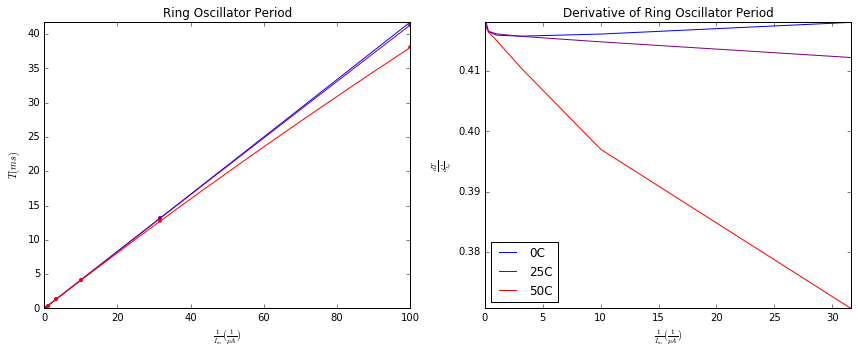

In [26]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto10pA.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_Temp"+str(curTemp)+"C_NoBuf_Ib100p_C1_1x_C2_2x_Iin1x.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

### Iin range 10fA to 10pA, C1 1x, C2 3x, Iin 2x, Ib 100p
This is the best result we had in the original notebook, except that Ib was 500p.  Also, previously, when we tested this configuration, we had set the Iin range from 100fA to 10pA.  Now we are testing an order of magnitude lower.  This test will see if there are still problems and how they manifest themselves in this circuit with wider range and smaller bias current.

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_Final/AH_FreqMeas_Temp0C_NoBuf_Ib100p_C1_1x_C2_3x_Iin2x.csv
Temp: 0	Relative RMSE: 0.035291%	Params: [  3.13137844e-01   2.14366845e-03   1.85453660e-05]
AH_Final/AH_FreqMeas_Temp25C_NoBuf_Ib100p_C1_1x_C2_3x_Iin2x.csv
Temp: 25	Relative RMSE: 0.016493%	Params: [  3.14309153e-01   1.38391204e-03  -1.47004592e-04]
AH_Final/AH_FreqMeas_Temp50C_NoBuf_Ib100p_C1_1x_C2_3x_Iin2x.csv
Temp: 50	Relative RMSE: 0.246745%	Params: [ 0.31200386  0.00764491 -0.00109457]

 Iins		Percent Error
 0.010 pA	  10.755%   
 0.032 pA	   3.814%   
 0.100 pA	   0.934%   
 0.316 pA	   0.111%   
 1.000 pA	   0.530%   
 3.162 pA	   1.074%   
10.000 pA	   2.790%   


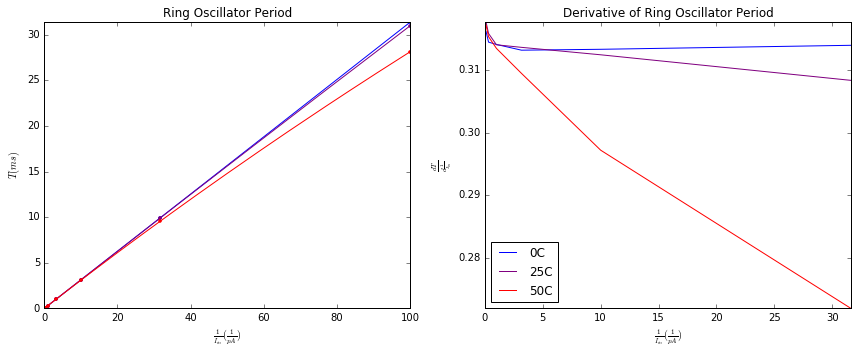

In [27]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto10pA.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_Temp"+str(curTemp)+"C_NoBuf_Ib100p_C1_1x_C2_3x_Iin2x.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

### Iin range 10fA to 10pA, C1 1x, C2 3x, Iin 2x, Ib 500p
Because the previous circuit behaved poorly, we wanted to test the exact same configuration that was successful before.

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_Final/AH_FreqMeas_Temp0C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x.csv
Temp: 0	Relative RMSE: 0.020733%	Params: [  3.13167099e-01   1.79674735e-03   2.65046194e-05]
AH_Final/AH_FreqMeas_Temp25C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x.csv
Temp: 25	Relative RMSE: 0.007210%	Params: [  3.14198621e-01   9.71629545e-04  -1.03941307e-04]
AH_Final/AH_FreqMeas_Temp50C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x.csv
Temp: 50	Relative RMSE: 0.072716%	Params: [ 0.31411112  0.00252036 -0.00091321]

 Iins		Percent Error
 0.010 pA	   8.599%   
 0.032 pA	   2.628%   
 0.100 pA	   0.638%   
 0.316 pA	   0.154%   
 1.000 pA	   0.141%   
 3.162 pA	   0.102%   
10.000 pA	   0.523%   


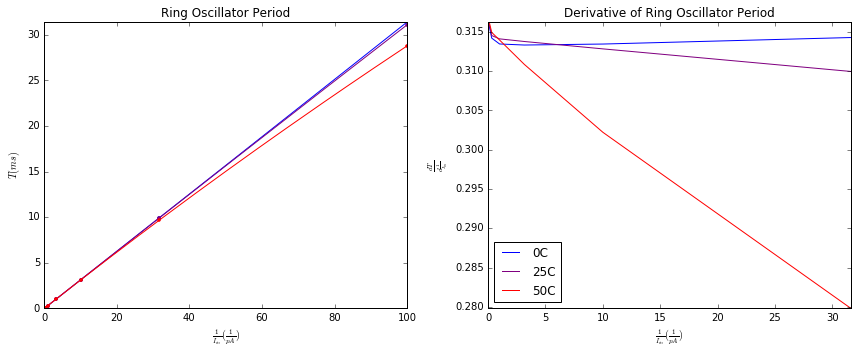

In [28]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto10pA.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_Temp"+str(curTemp)+"C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

## Asymmetric current sources (single bias system)
We are seeing poor results at small currents.  We think the problem could be coming from large gate leakages entering the circuit and being a larger percentage of the error in this input current regime.  As such, we are now going to test making the circuit charge and discharge asymmetrically.  This will ideally help us in two ways.  The first way is by making the circuit operate almost twice as fast, b/c we're going to try and cut out the discharging phase.  The second way is by ideally removing gate leakage from the problem by getting rid of NFET circuits.

### ACS - Iin range 10fA to 10pA, C1 1x, C2 3x, Iin 2x, Ib 500p
This is the asymmetric current source (ACS) configuration of the best result.

A lot of time and effort went into characterizing this, only to find that we can't get good temperature mismatch with any of our possible proposed asymmetric designs.  As such, we're going to go back to KB mirror.  We want to reduce the channel leakage of the NFETs by shifting the RBB (reverse body bias)

## Symmetric current sources
We are now converging on a solution to use the symmetric circuit.  While debugging the asymmetric circuit, I realized that we could add a couple of capacitors to the gates of the current mirror to help the circuit behave more linearly.  This helps to speed up the circuit, b/c there are no extra oscillations that slow down the $V_{cap}$ node from immediately charging/discharging.  This can be seen in the schematic below, with C3 and C4.  For now they are idealized so that I can understand how much capacitance is necessary.

Another thing we want to try, as mentioned before, is changing the RBB voltage in the circuit to help with leakage of the NFETs.

This section will be a compilation of the tests where I vary some of these parameters to see how well we can optimize the circuit's behavior.

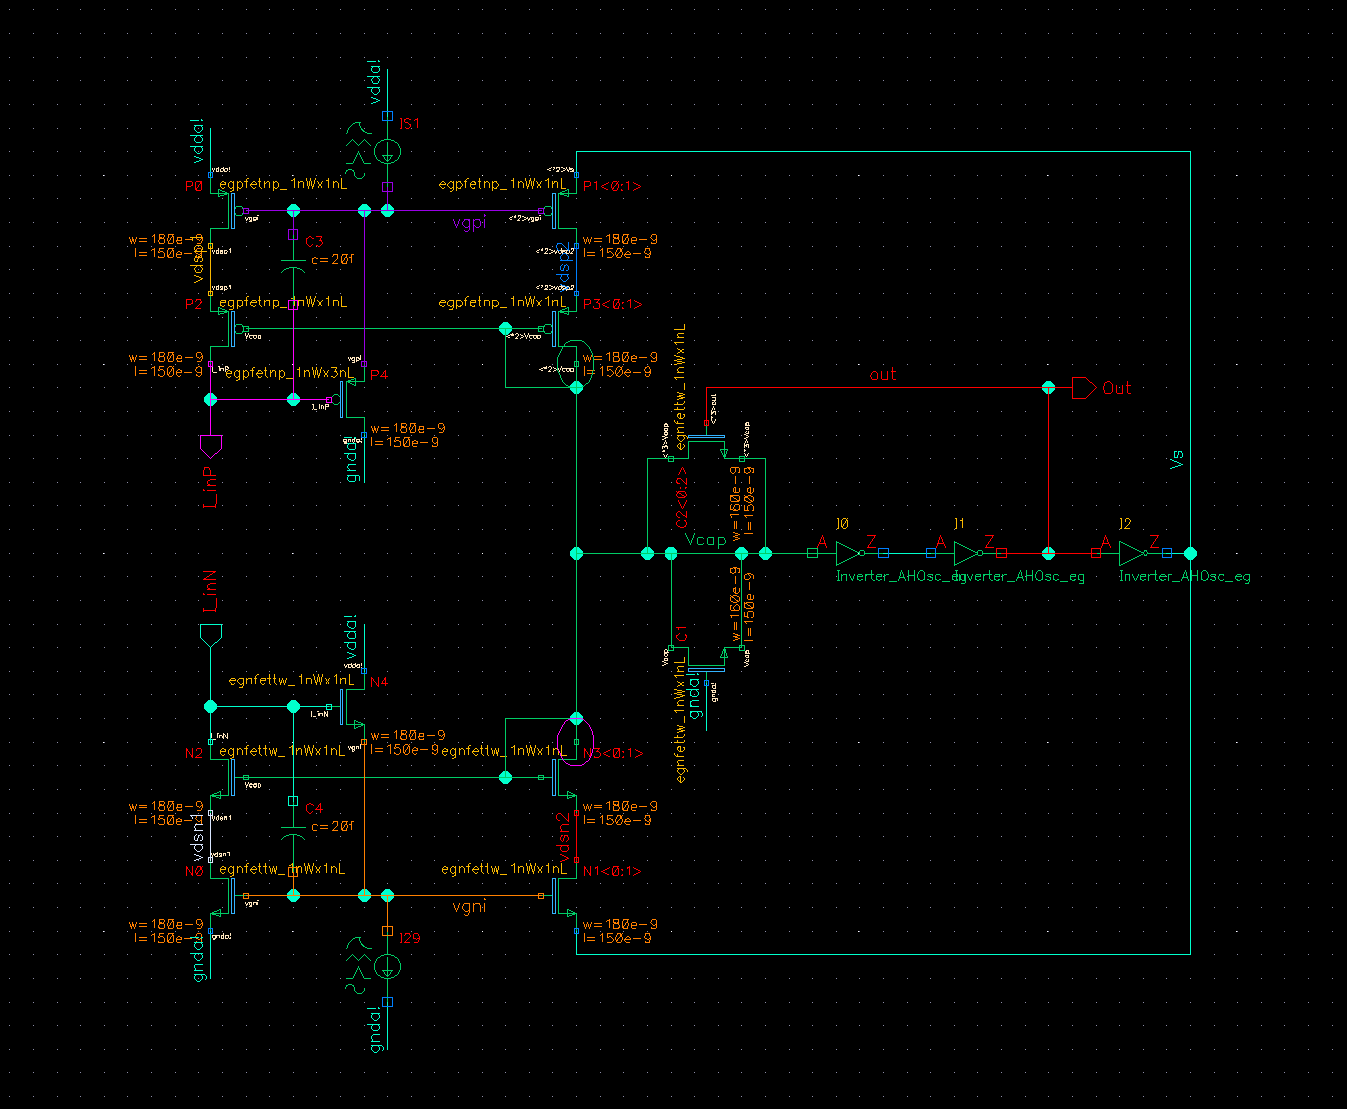

In [27]:
Image(folderPath + "SchematicImages/AHConfig_KB_C1_1x_C2_3x_Iin2x_IdealPZCCap.png", width=800)

### Baseline
This the same results we found before, but for a wider input current range.  This is the baseline for the best symmetric design we have up until now: C1 1x, C2 3x, Iin 2x, and no PZCCaps (Pole-Zero Compensation caps) or GateCaps.

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11   3.16227766e-11
   1.00000000e-10]
AH_Final/AH_FreqMeas_Temp0C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x.csv
Temp: 0	Relative RMSE: 0.028127%	Params: [  3.13044268e-01   1.41325643e-03   1.07708708e-05]
AH_Final/AH_FreqMeas_Temp25C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x.csv
Temp: 25	Relative RMSE: 0.013600%	Params: [  3.14146202e-01   7.99544242e-04  -1.46363248e-04]
AH_Final/AH_FreqMeas_Temp50C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x.csv
Temp: 50	Relative RMSE: 0.204524%	Params: [ 0.31236475  0.00399141 -0.00097799]

 Iins		Percent Error
 0.010 pA	   9.524%   
 0.032 pA	   3.319%   
 0.100 pA	   0.832%   
 0.316 pA	   0.178%   
 1.000 pA	   0.089%   
 3.162 pA	   0.116%   
10.000 pA	   0.397%   
31.623 pA	   1.183%   
100.000 pA	   6.992%   


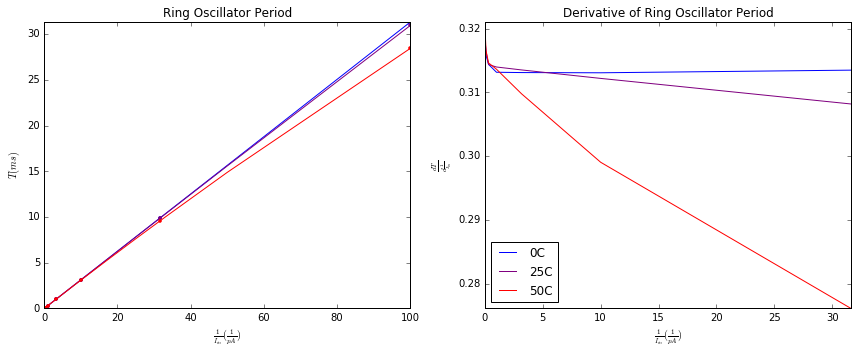

In [28]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto100pA.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_Temp"+str(curTemp)+"C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

We found that the reason this circuit fails at large currents is because the Vds of the current mirrors goes into the ohmic region.  This is caused by the fact that there is a Vgs drop from the Vcap line determined by the input current.  When this input current is large, the Vgs value is large and therefore the Vds across the mirrors is small.

### Adding Gate Caps
We noticed that the gates of the mirrors had some violent swinging on them in certain scenarios.  In order to mitigate this, we added some capacitors to the gates to try and dampen the ringing occuring on these lines.
#### GC 1fF

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_Final/AH_FreqMeas_KB_Temp0C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap1f.csv
Temp: 0	Relative RMSE: 0.018245%	Params: [  3.13071096e-01   1.65823001e-03   3.73674644e-05]
AH_Final/AH_FreqMeas_KB_Temp25C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap1f.csv
Temp: 25	Relative RMSE: 0.007384%	Params: [  3.14313987e-01   5.64240543e-04  -1.06188357e-04]
AH_Final/AH_FreqMeas_KB_Temp50C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap1f.csv
Temp: 50	Relative RMSE: 0.041696%	Params: [ 0.31467589  0.00154141 -0.00100098]

 Iins		Percent Error
 0.010 pA	   9.284%   
 0.032 pA	   2.720%   
 0.100 pA	   0.641%   
 0.316 pA	   0.191%   
 1.000 pA	   0.211%   
 3.162 pA	   0.192%   
10.000 pA	   0.815%   


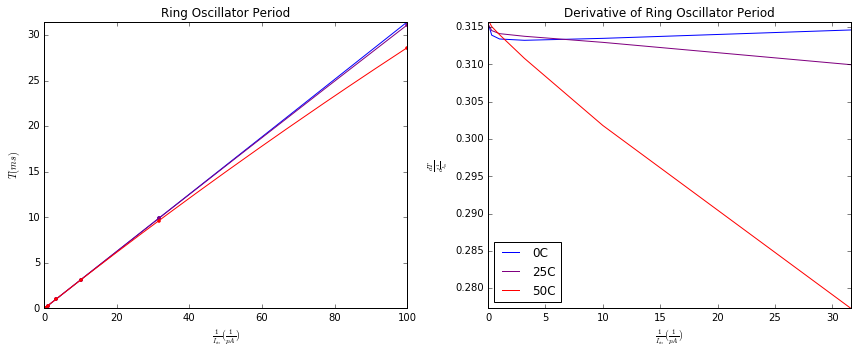

In [31]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto10pA_7steps.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_KB_Temp"+str(curTemp)+"C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap1f.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

#### GC 5fF

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_Final/AH_FreqMeas_KB_Temp0C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f.csv
Temp: 0	Relative RMSE: 0.017932%	Params: [  3.13093066e-01   1.61760389e-03   3.72105456e-05]
AH_Final/AH_FreqMeas_KB_Temp25C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f.csv
Temp: 25	Relative RMSE: 0.006595%	Params: [  3.14310144e-01   5.54133574e-04  -1.05575411e-04]
AH_Final/AH_FreqMeas_KB_Temp50C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f.csv
Temp: 50	Relative RMSE: 0.041787%	Params: [ 0.31467626  0.00154347 -0.00100036]

 Iins		Percent Error
 0.010 pA	   9.283%   
 0.032 pA	   2.725%   
 0.100 pA	   0.640%   
 0.316 pA	   0.183%   
 1.000 pA	   0.222%   
 3.162 pA	   0.215%   
10.000 pA	   0.561%   


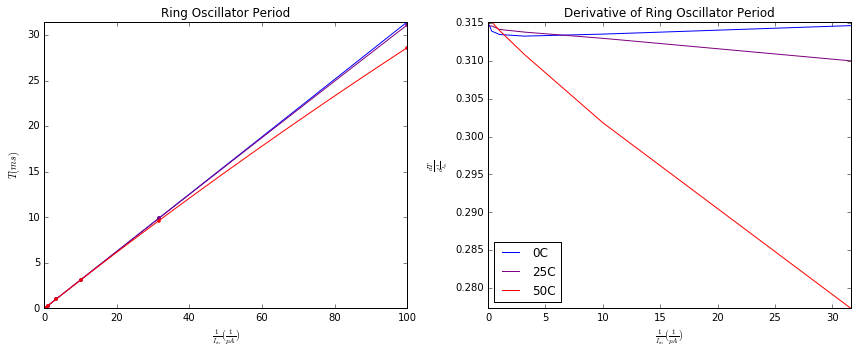

In [32]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto10pA_7steps.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_KB_Temp"+str(curTemp)+"C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

### Varying RBB
In the previous tests, our RBB was set to be -1V for both NFET and PFET.  In the following tests, I vary the RBB value to -2 and -1.5V.

We are playing with the RBB value to see if we can lower the leakage current of the NFETs (and the PFETs) to make it so that this circuit operates better at the smaller currents.  Our current hypothesis is that the smaller currents are failing because leakage current starts to be come a significant percentage of the error.
#### RBB  -1.5V

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_Final/AH_FreqMeas_KB_Temp0C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f_RBB-1.5V.csv
Temp: 0	Relative RMSE: 0.052759%	Params: [  3.13684801e-01   5.02515509e-03   6.30845838e-05]
AH_Final/AH_FreqMeas_KB_Temp25C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f_RBB-1.5V.csv
Temp: 25	Relative RMSE: 0.022444%	Params: [  3.14424035e-01   2.50380144e-03   4.76366807e-05]
AH_Final/AH_FreqMeas_KB_Temp50C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f_RBB-1.5V.csv
Temp: 50	Relative RMSE: 0.008571%	Params: [  3.15704709e-01   9.77225949e-04  -1.65687805e-04]

 Iins		Percent Error
 0.010 pA	   1.715%   
 0.032 pA	   0.275%   
 0.100 pA	   0.183%   
 0.316 pA	   0.131%   
 1.000 pA	   0.685%   
 3.162 pA	   1.932%   
10.000 pA	   4.782%   


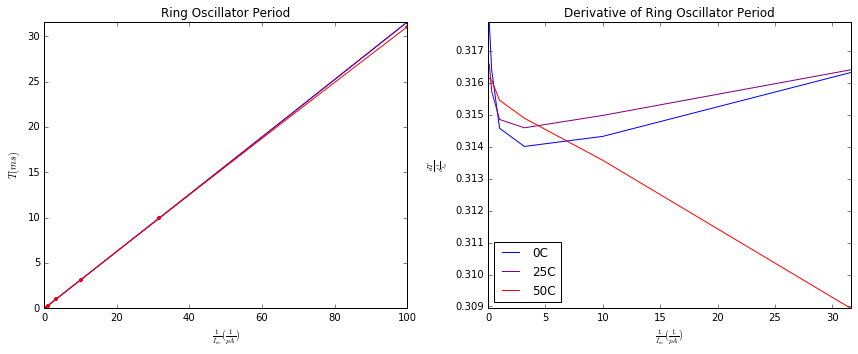

In [33]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto10pA_7steps.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_KB_Temp"+str(curTemp)+"C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f_RBB-1.5V.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

#### RBB -2V
##### GateCap 5fF

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_Final/AH_FreqMeas_KB_Temp0C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f_RBB-2V.csv
Temp: 0	Relative RMSE: 0.143316%	Params: [  3.15358244e-01   1.77692640e-02   6.76990280e-05]
AH_Final/AH_FreqMeas_KB_Temp25C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f_RBB-2V.csv
Temp: 25	Relative RMSE: 0.078085%	Params: [  3.15184081e-01   7.82872094e-03   9.30949931e-05]
AH_Final/AH_FreqMeas_KB_Temp50C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f_RBB-2V.csv
Temp: 50	Relative RMSE: 0.032962%	Params: [  3.15920412e-01   3.88724004e-03   5.43685534e-05]

 Iins		Percent Error
 0.010 pA	   0.170%   
 0.032 pA	   0.084%   
 0.100 pA	   0.494%   
 0.316 pA	   1.549%   
 1.000 pA	   3.809%   
 3.162 pA	  10.736%   
10.000 pA	  25.147%   


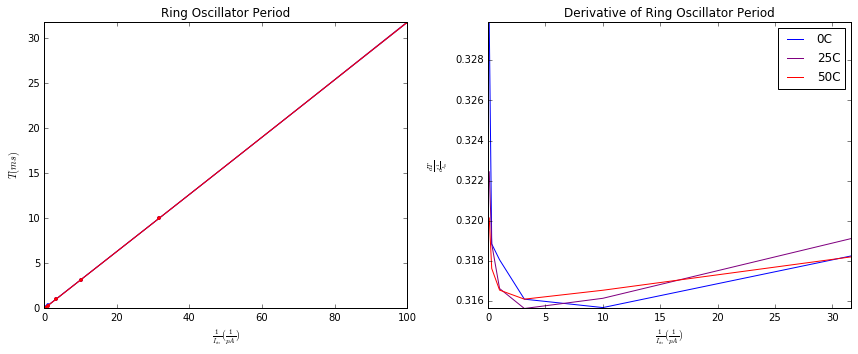

In [34]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto10pA_7steps.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_KB_Temp"+str(curTemp)+"C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap5f_RBB-2V.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

##### GateCap 2fF

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_Final/AH_FreqMeas_KB_Temp0C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap2f_RBB-2V.csv
Temp: 0	Relative RMSE: 0.141449%	Params: [  3.15290237e-01   1.80405308e-02   6.96152249e-05]
AH_Final/AH_FreqMeas_KB_Temp25C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap2f_RBB-2V.csv
Temp: 25	Relative RMSE: 0.076304%	Params: [  3.15173114e-01   7.88292693e-03   9.28326832e-05]
AH_Final/AH_FreqMeas_KB_Temp50C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap2f_RBB-2V.csv
Temp: 50	Relative RMSE: 0.031981%	Params: [  3.15927112e-01   3.86352056e-03   5.40836593e-05]

 Iins		Percent Error
 0.010 pA	   0.164%   
 0.032 pA	   0.089%   
 0.100 pA	   0.498%   
 0.316 pA	   1.516%   
 1.000 pA	   3.751%   
 3.162 pA	  10.777%   
10.000 pA	  27.414%   


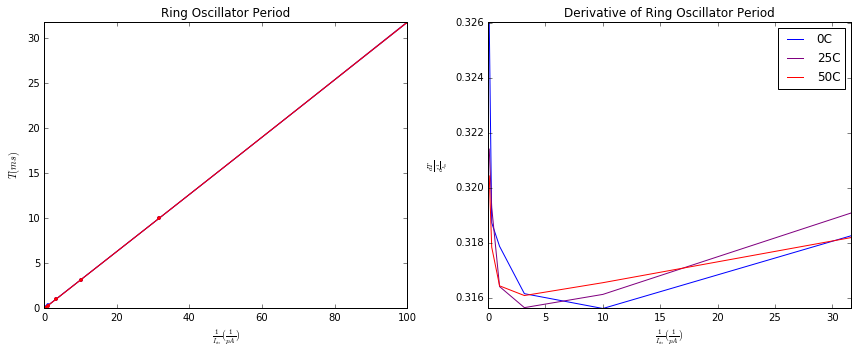

In [9]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto10pA_7steps.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_KB_Temp"+str(curTemp)+"C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_GateCap2f_RBB-2V.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

### Varying PZCCaps
#### C3, C4 = 20fF

Temps:  [0, 25, 50]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11   3.16227766e-11
   1.00000000e-10]
AH_Final/AH_FreqMeas_Temp0C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_PZCCap20f.csv
Temp: 0	Relative RMSE: 0.078162%	Params: [  3.13058965e-01   3.36996314e-03   5.41285234e-06]
AH_Final/AH_FreqMeas_Temp25C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_PZCCap20f.csv
Temp: 25	Relative RMSE: 0.045413%	Params: [  3.14553181e-01   2.89658933e-03  -2.16878798e-04]
AH_Final/AH_FreqMeas_Temp50C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_PZCCap20f.csv
Temp: 50	Relative RMSE: 0.457922%	Params: [ 0.30899882  0.01080253 -0.00114497]

 Iins		Percent Error
 0.010 pA	  11.982%   
 0.032 pA	   4.908%   
 0.100 pA	   1.402%   
 0.316 pA	   0.146%   
 1.000 pA	   0.175%   
 3.162 pA	   1.393%   
10.000 pA	   5.424%   
31.623 pA	  11.445%   
100.000 pA	  14.340%   


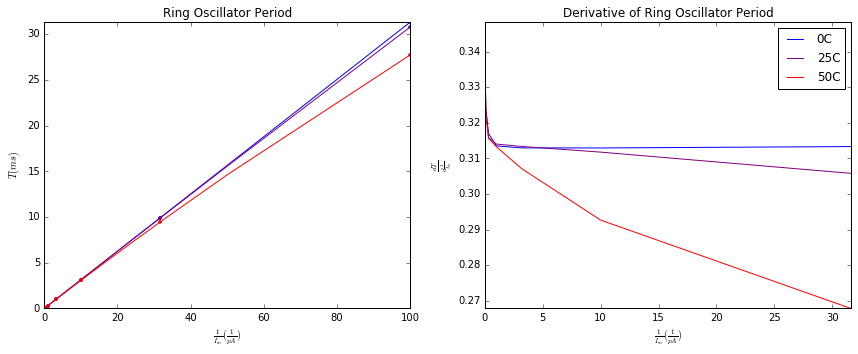

In [10]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_SmallIins_10fAto100pA.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_Final/AH_FreqMeas_Temp"+str(curTemp)+"C_NoBuf_Ib500p_C1_1x_C2_3x_Iin2x_PZCCap20f.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode